#  Предсказания закрытия стартапов

## Цель проекта
В этом проекте нам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Соревнование проводится на популярной платформе Kaggle.

В этом конкурсе наша задача - разработать модель для предсказания успешности стартапа (закроется или нет).

__Данные__

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

_Датасеты_:
- kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
- kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.

Поле name - идентификатор (название) стартапа в тестовом наборе, status - целевой признак. Для каждого стартапа нужно предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].

_Признаки датасетов_:

Описание полей данных
name - Название стартапа
category_list - Список категорий, к которым относится стартап
funding_total_usd - Общая сумма финансирования в USD
status - Статус стартапа (закрыт или действующий)
country_code - Код страны
state_code - Код штата
region - Регион
city - Город
funding_rounds - Количество раундов финансирования
founded_at - Дата основания
first_funding_at - Дата первого раунда финансирования
last_funding_at - Дата последнего раунда финансирования
closed_at - Дата закрытия стартапа (если применимо)
lifetime - Время существования стартапа в днях

__Оценка качества предсказаний__
Метрикой в этом соревновании является F1-Score. F1-мера вычисляется на основе точности p и полноты r. Точность - это отношение true positives (tp) ко всем predicted positives (tp + fp). Полнота это отношение true positives ко всем actual positives (tp + fn). Тогда F1 задается формулой:

Метрика F1 является гармоническим средним между Recall и Precision. Хорошая модель при обучении будет максимизировать Recall и Precision одновременно. Таким образом, умеренно хорошие показатели по обоим параметрам будут предпочтительнее, чем чрезвычайно хорошие показатели по одному и плохие по другому.


## Загрузка данных

In [1]:
# устанавливаем необходимые компоненты
!pip install phik -q
#!pip install --upgrade scikit-learn -q
#!pip install shap -q

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as stb
import math
import os
from IPython.display import display

import phik
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score
import shap

RANDOM_STATE = 42
TEST_SIZE = 0.25

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
sns.set_theme(style='darkgrid')
pd.set_option('display.float_format', '{:,.3f}'.format)

In [3]:
# загружаем данные из файлов в датафремы

pth1, pth2, pth3 = (r"datasets\kaggle_startups_train_28062024.csv",
                    r"datasets\kaggle_startups_test_28062024.csv",
                    r"datasets\kaggle_startups_sample_submit_28062024.csv")

if os.path.exists(pth1) and os.path.exists(pth2) and os.path.exists(pth3):
    startups_train = pd.read_csv(pth1, sep=',', parse_dates=['founded_at','first_funding_at','last_funding_at'], dayfirst=True)
    startups_test = pd.read_csv(pth2, sep=',', parse_dates=['first_funding_at','last_funding_at'], dayfirst=True)
    submit_sample = pd.read_csv(pth3, sep=',')
# if os.path.exists(pth1) and os.path.exists(pth2) and os.path.exists(pth3):
#     startups_train = pd.read_csv(pth1, sep=',')
#     startups_test = pd.read_csv(pth2, sep=',')
#     submit_sample = pd.read_csv(pth3, sep=',')

else:
    print('Проверьте правильность написания пути к файлам или их доступность по указанному адресу')

In [4]:
# составляем список датафреймов и их имен
dfs = [startups_train, startups_test, submit_sample]
name_dfs = ['startups_train', 'startups_test', 'submit_sample']

# функция для отображения информации по df, первые строки, типы данных, размер
def data_view(df):
    display(df.head())
    print('\n\033[1mИнформация по составу датафрейма:\033[0m\n')
    df.info()
    print('\n\n')

In [5]:
# цикл для просмотра информации по данным датафремов
def df_view(dfs, name_dfs):
    i = 0
    for df in dfs:
        print(f'\033[1mДатафрейм {name_dfs[i]}:\033[0m')
        data_view(df)
        i += 1

In [6]:
df_view(dfs, name_dfs)

Датафрейм startups_train:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,"22,250,000.000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN



Информация по составу датафрейма:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   object        
dtypes: datetime64[ns](3), flo

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.000",NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,"428,257.000",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.000",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,"4,530,000.000",CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209



Информация по составу датафрейма:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB



Датафрейм submit_sample:


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating



Информация по составу датафрейма:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB





In [7]:
min = startups_train['founded_at'].min()
max = startups_train['founded_at'].max()
print(f'Даты открытия самого первого и последнего стартапа в нашем датасете: {min.date()} и {max.date()}')

Даты открытия самого первого и последнего стартапа в нашем датасете: 1970-02-05 и 2016-04-02


### Вывод по загрузке дынных

Загрузили данные, создали датафреймы и просмотрели необходимую информацию, которую будем использовать в проекте. Выяснили, что не будем проводить предобработку данных датафрейма **target_test**, так как он не будет использоваться при обучении или тестировании, а пригодится нам только для формализации формы результатов для дальнейшей загрузки на kaggle и участия в соревновании. Рассмотрели размер датафреймов, типы данных, сразу можно сказать, что необходимо подумать над преобразованием столбцов, которые включают в себя даты и на данный момент представлены типом object. 

По общей информации в датафреймах видно присутствие значительного количества пропусков. На первый взгляд, типы данных в датафреймах определены верно, названия столбцов также соответствуют стандартам. Переходим к предобработке данных.

## Предобработка данных

### Проверка корректности оформления столбцов и типов данных

In [8]:
# функция, которая выдает размер датафрейма
def dfs_size(dfs):
    i = 0
    for df in dfs:    
        print(f'Размер датафрейма \033[1m{name_dfs[i]}\033[0m: строк - {df.shape[0]}, столбцов - {df.shape[1]}')
        i += 1

In [9]:
# убираем из списка образец вывода результатов после обучения модели
dfs = [startups_train, startups_test]
name_dfs = ['startups_train', 'startups_test']

Посмотрим внимательно на названия столбцов датафреймов

In [10]:
for df in dfs:
    display(df.columns)

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime'],
      dtype='object')

Отметим следующие отличия в представленных данных между тренировочным и тестовым датафреймами:

- в train есть столбцы _founded_at_ и _closed at_, но нет _lifetime_ (также нет _status_, так как это таргет);
- в test, наоборот, есть _lifetime_ и нет _founded_at_ и _closed at._

### Анализ пропущенных значений

In [11]:
# Функция, которая выдает размер датафрейма
def dfs_size(dfs):
    i = 0
    for df in dfs:    
        print(f'Размер датафрейма \033[1m{name_dfs[i]}\033[0m: строк - {df.shape[0]}, столбцов - {df.shape[1]}')
        i += 1

In [12]:
# Пишем функцию для отсображения кол-ва, процента пропущенных значений и типа данных
def numb_isna(df, plot):
    isna_types = pd.concat([df.isna().sum(),(df.isna().sum() / df.isna().count() * 100).round(2),
                            df.dtypes],axis=1)
    isna_types.columns = ['sum_isna','percent_isna','value_type']
    isna_types.sort_values(by='sum_isna', ascending=False)

    if plot:
        # Строим тепловую карту
        colours = ['#000000', '#40E0D0'] # определяем цвета, бирюзовый - пропущенные данные, черный - не пропущенные
        fig = plt.subplots(figsize=(12, 6))
        sns.heatmap(df.isna(),cmap=sns.color_palette(colours),cbar= False)
    
        plt.title('Тепловая карта пропусков', fontsize = 14)
        plt.xlabel('Название столбца', fontsize = 12)
        plt.ylabel('Кол-во пропусков', fontsize = 12)
        plt.xticks(rotation=15)
        plt.show();
    
    return isna_types

startups_train:


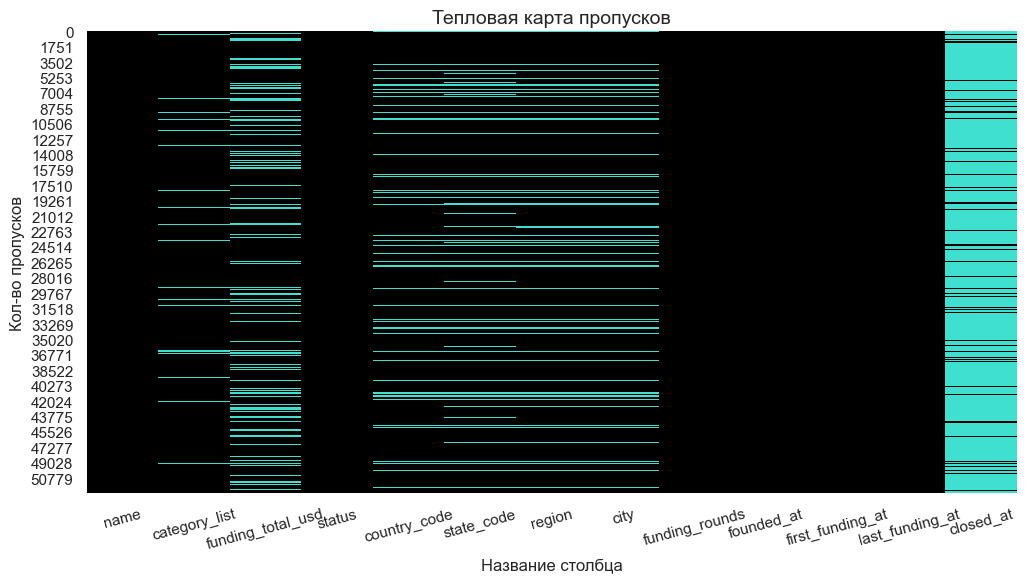

,sum_isna,percent_isna,value_type
name,1,0.000,object
category_list,2465,4.690,object
funding_total_usd,10069,19.170,float64
status,0,0.000,object
country_code,5502,10.480,object
state_code,6763,12.880,object
region,6359,12.110,object
city,6359,12.110,object
funding_rounds,0,0.000,int64
founded_at,0,0.000,datetime64[ns]





startups_test:


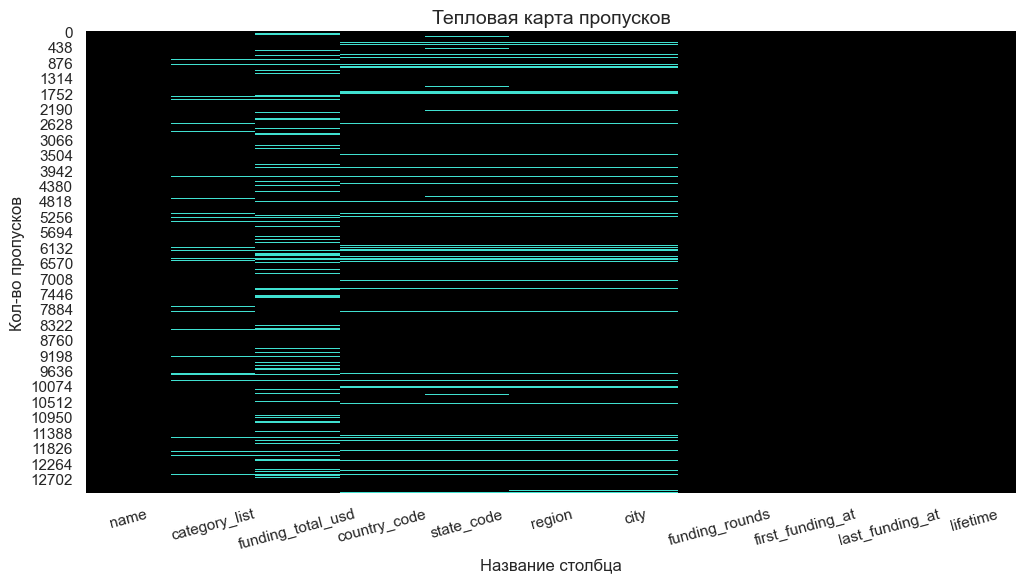

,sum_isna,percent_isna,value_type
name,0,0.000,object
category_list,591,4.500,object
funding_total_usd,2578,19.640,float64
country_code,1382,10.530,object
state_code,1695,12.910,object
region,1589,12.110,object
city,1587,12.090,object
funding_rounds,0,0.000,int64
first_funding_at,0,0.000,datetime64[ns]
last_funding_at,0,0.000,datetime64[ns]


In [13]:
# Выводим таблицу для каждого датафрейма выводим таблицу
j = 0

for df in dfs:
    print(f'\033[1m{name_dfs[j]}:\033[0m')
    display(numb_isna(df,True))
    print('\n\n')
    j += 1

Можно заметить, что процентное соотношение пропусков по столбцам в тренировочной и тестовой выборке очень близко. Начнем разбирать пропуски и с чем они могут быть связаны.

Мы видим большое количестов пропусков в тренировочной выборки в столбце closed_at, который, скорее всего, связан с тем что стартап еще функционирует. Это можно проверить рассмотрев столбцы с нашим таргетом и датой закрытия.

#### признак closed_at

In [14]:
dfs[0][['closed_at','status']]

,closed_at,status
0,NaN,operating
1,NaN,operating
2,NaN,operating
3,NaN,operating
4,NaN,operating
...,...,...
52511,NaN,operating
52512,NaN,operating
52513,NaN,operating
52514,NaN,operating


In [15]:
# количество строк, в которых есть информация о закрытии стартапа
dfs[0].query('status == "closed"').count()

name                 4916
category_list        4188
funding_total_usd    3892
status               4917
country_code         3631
state_code           3523
region               3550
city                 3550
funding_rounds       4917
founded_at           4917
first_funding_at     4917
last_funding_at      4917
closed_at            4917
dtype: int64

In [16]:
# количество строк, в которых стартап еще на плаву и дата закрытия не равна NaN
dfs[0].query('~(closed_at.isna() and status == "operating")').count()

name                 4916
category_list        4188
funding_total_usd    3892
status               4917
country_code         3631
state_code           3523
region               3550
city                 3550
funding_rounds       4917
founded_at           4917
first_funding_at     4917
last_funding_at      4917
closed_at            4917
dtype: int64

In [17]:
dfs[0].query('(~closed_at.isna() and status == "operating")').count()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
closed_at            0
dtype: int64

Можно сказать, что наше предположение очень похоже на правду, оставим пропуски как есть, на основе этого столбца в будущем попробуем синтезировать новый признак.

#### признаки country_code, state_code, region, city

Далее, мы видим достаточно большое количество пропусков, от 10 до 20 процентов в данных по общей сумме вложенных в стартап средств, коду страны, коду штата, регионе и городе, в котором находится стартап. 

In [40]:
numb_isna(dfs[0][['country_code','state_code','region','city']], False)

,sum_isna,percent_isna,value_type
country_code,3260,9.510,object
state_code,4107,11.980,object
region,3830,11.180,object
city,3830,11.180,object


In [42]:
dfs[0][['country_code','state_code','region','city']].query('country_code.isna() and not city.isna()')

,country_code,state_code,region,city


In [43]:
dfs[0][['country_code','state_code','region','city']].query('country_code.isna() and city.isna()')

,country_code,state_code,region,city
12,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN
...,...,...,...,...
52442,NaN,NaN,NaN,NaN
52444,NaN,NaN,NaN,NaN
52455,NaN,NaN,NaN,NaN
52473,NaN,NaN,NaN,NaN


In [46]:
dfs[0][['country_code','state_code','region','city']].query('country_code.isna() or city.isna() or state_code.isna() or region.isna()')

,country_code,state_code,region,city
12,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN
50,AUS,NaN,NaN,NaN
...,...,...,...,...
52442,NaN,NaN,NaN,NaN
52444,NaN,NaN,NaN,NaN
52455,NaN,NaN,NaN,NaN
52473,NaN,NaN,NaN,NaN


#### признак category_list

In [19]:
dfs[0].query('category_list.isna()')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
12,Iberic Premium,NaN,"107,239.000",closed,NaN,NaN,NaN,NaN,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
26,The Center from Health Promotion,NaN,"10,000,000.000",operating,NaN,NaN,NaN,NaN,1,2002-04-21,2003-11-12,2003-11-12,NaN
64,Seamless Logistics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-02-22,2011-02-01,2011-02-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52404,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30
52419,"iSend, LLC",NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-01-01,2008-05-28,2008-05-28,2009-10-03
52467,Thermal Nomad,NaN,NaN,operating,USA,TX,Houston,Houston,1,2014-04-20,2014-05-28,2014-05-28,NaN
52473,Vision Software PTY,NaN,"15,000,000.000",operating,NaN,NaN,NaN,NaN,1,1998-01-10,1999-11-02,1999-11-02,NaN


Около 5% пропусков связано с отсутсвием категории компании-стартапа, их мы отнесем к категории "другие".

#### признак funding_total_usd

Посмотреть внимательнее на взаимосвязь таргета и этого признака, если почти все эти стартапы закрылись, можно предположить, что они так и не получили финансирование

#### признак name

In [20]:
dfs[0].query('(name.isna())')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,"25,000.000",closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


Один пропуск у нас есть в графе названия компании, мы будем брать название как уникальный идентификатор, так что для нас это столбец критичен, придумаем название этой компании самостоятельно.

In [21]:
dfs[0]['name'] = dfs[0]['name'].fillna('NEW_STARTUP')

In [22]:
dfs[0][dfs[0]['name'] == 'NEW_STARTUP']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NEW_STARTUP,Startups,"25,000.000",closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [23]:
dfs_size(dfs)

Размер датафрейма startups_train: строк - 52516, столбцов - 13
Размер датафрейма startups_test: строк - 13125, столбцов - 11


### Проверка наличия явных и неявных дубикатов

In [24]:
# Смотрим наличие дубликатов в датафреймах
i = 0

for df in dfs:
    print(f'Количество явных дубликатов до обработки: \033[1m{name_dfs[i]}\033[0m: {df.duplicated().sum()}')
    display(df[df.duplicated()])
    print('-' * 120)
    i += 1

Количество явных дубликатов до обработки: startups_train: 0


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


------------------------------------------------------------------------------------------------------------------------
Количество явных дубликатов до обработки: startups_test: 0


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


------------------------------------------------------------------------------------------------------------------------


Явных дубликатов в данных также не замечено. Посмотрим на неявные дубликаты.

In [25]:
# cмотрим уникальные значения по столбцам датафреймов, 
# с целью выявления неявных дубликатов и ошибок, возможных при вводе данных

i = 0
for df in dfs:
    print(f'\033[1m{name_dfs[i]}\033[0m:')
    i += 1
    for col in df.columns:
        print(f'{df[col].name}:\n {df[col].unique()}\n')

startups_train:
name:
 ['Lunchgate' 'EarLens' 'Reviva Pharmaceuticals' ... 'Taskforce'
 'NetScaler' 'Apparcando']

category_list:
 ['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']

funding_total_usd:
 [  828626. 42935019. 35456381. ...  4582414.  3209000.   270820.]

status:
 ['operating' 'closed']

country_code:
 ['CHE' 'USA' nan 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS' 'TWN'
 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD' 'ARG'
 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA' 'GRC'
 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA' 'JOR'
 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX' 'SVN'
 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA' 'TTO'
 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT' 'PSE'
 'BLZ

На первый взгляд, никаких критически важных дубликатов не обнаружено, отсутсвуют лишние пробелы или какие-то другие символы.

In [26]:
dfs_size(dfs)

Размер датафрейма startups_train: строк - 52516, столбцов - 13
Размер датафрейма startups_test: строк - 13125, столбцов - 11


In [27]:
dfs[0]['name'].nunique()

52516

Убедились, что названия всех стартапов уникальны, это важно, так как именно этот признак послужит нашим уникальным ключом.

### Вывод по предобработке данных
__Чем дополнить можно: Перевести даты в формат дат, разделить по вертикальной черте категории компаний__

In [28]:
#pd.set_option('display.max_rows', None)

dfs[0]['category_list']

0               Online Reservations|Restaurants
1         Manufacturing|Medical|Medical Devices
2                                 Biotechnology
3                                   Health Care
4                                 Manufacturing
                          ...                  
52511                             Entertainment
52512                               Hospitality
52513     Email|Messaging|Productivity Software
52514                                  Security
52515    Online Rental|Parking|Price Comparison
Name: category_list, Length: 52516, dtype: object

## Исследовательский анализ данных

### Анализ количественных признаков

Первым делом посмотрим на статистическое описание количественных признаков столбцов датафреймов.

In [29]:
i = 0

for df in dfs:
    print(f'\n\033[1m{name_dfs[i]}\033[0m:')
    display(df.describe())
    i += 1


startups_train:


,funding_total_usd,funding_rounds
count,"42,447.000","52,516.000"
mean,"18,247,480.657",1.741
std,"187,117,301.321",1.375
min,1.000,1.000
25%,"336,027.500",1.000
50%,"2,000,000.000",1.000
75%,"10,000,000.000",2.000
max,"30,079,503,000.000",19.000



startups_test:


,funding_total_usd,funding_rounds,lifetime
count,"10,547.000","13,125.000","13,125.000"
mean,"16,549,102.695",1.714,"3,097.610"
std,"92,172,825.632",1.319,"2,128.357"
min,1.000,1.000,52.000
25%,"320,000.000",1.000,"1,726.000"
50%,"2,000,000.000",1.000,"2,526.000"
75%,"10,000,000.000",2.000,"3,866.000"
max,"4,715,000,000.000",15.000,"17,167.000"


Видим, что присутсвует очень большая разница между медианами и средними значениями в данных по сумме инвестиций, расхождения по количеству раундов, а также наличие выборосов в датафреймах. Перейдем к подробной оценке количественных значений, с визуализацией распределения значений.

In [30]:
# Функция для построения гистограммы и диаграммы распределения значений
def plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y_h,x_h,y_b,x_b):
    fig, axs = plt.subplots(subplots, 1, figsize=figsize)
    
    j = 0
    i = 0
    for col in columns:
        # Определение параметров построения гисторграммы
        sns.histplot(data=df[col], ax=axs[i],bins=bins[j], fill=True, kde=True)
        axs[i].set_title(title_h[j],fontsize=14)
        axs[i].set_ylabel(y_h[j])
        axs[i].set_xlabel(x_h[j])

        # Определение параметров построения boxplot
        i += 1  
        sns.boxplot(x=df[col],showmeans=True, ax=axs[i])
        axs[i].set_title(title_b[j],fontsize=14)
        axs[i].set_ylabel(y_b[j])
        axs[i].set_xlabel(x_b[j])
        
        plt.tight_layout()
        
        if i < subplots:
            i += 1
            j += 1

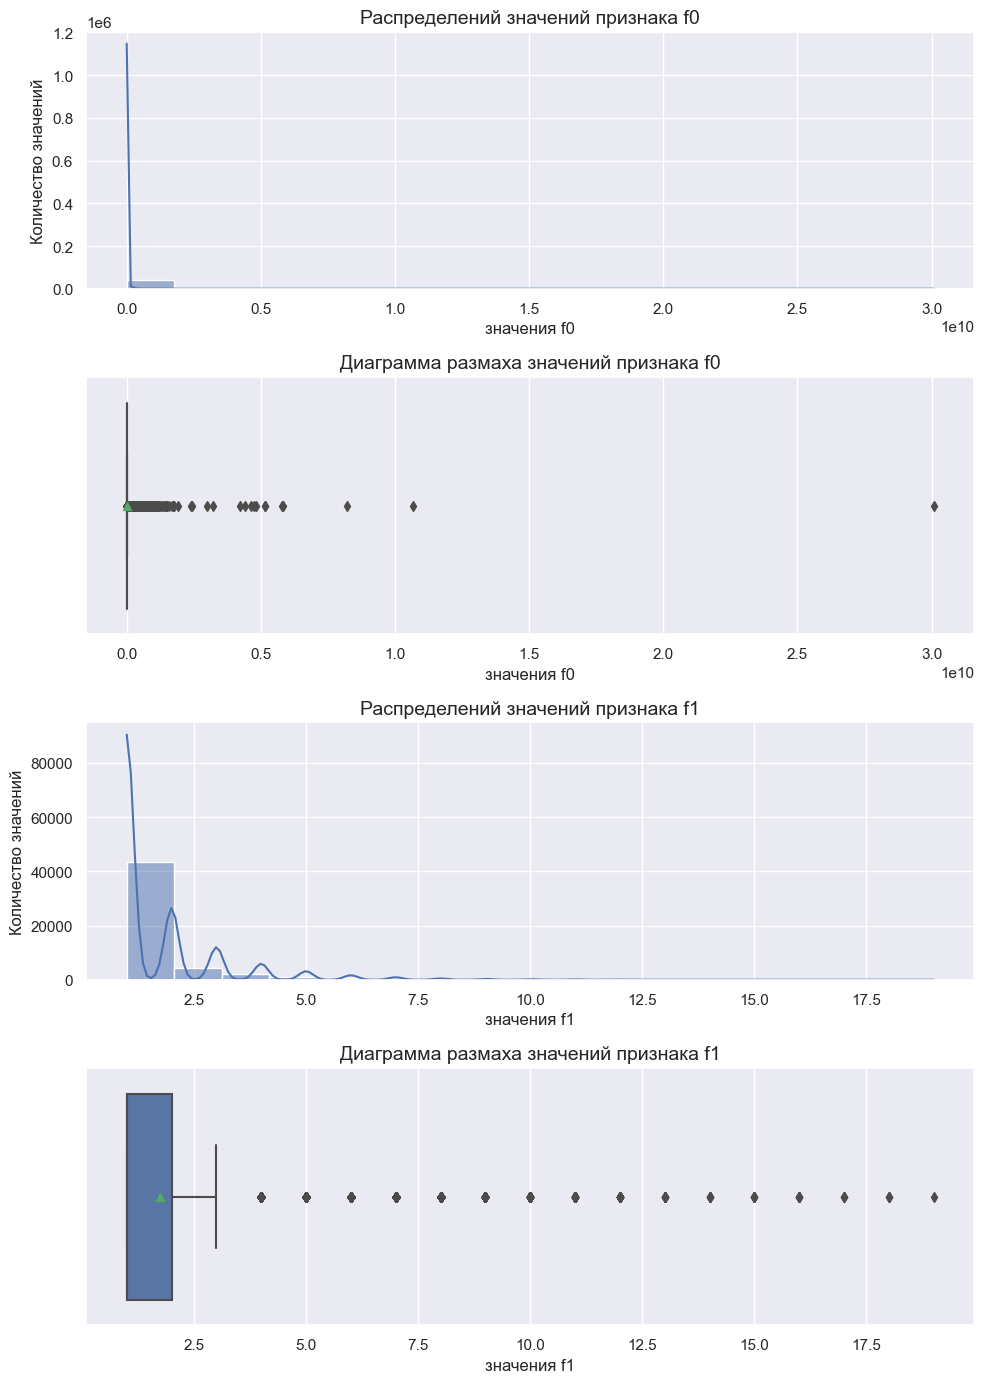

In [31]:
# Создаем переменные, которые станут агрументами функции
df = dfs[0]
columns = df.select_dtypes(include='number').columns.tolist()
col_numb = len(columns)
subplots = col_numb * 2

# Количество корзин определим по правилу Стёрджеса: число bins равно log2(n) + 1, где n - количество наблюдений
bins = [round((math.log2(len(dfs[0])) + 1))] * col_numb
figsize = (10,14)
title_h = ['Распределений значений признака f0','Распределений значений признака f1','Распределений значений признака f2',
           'Распределений запаса нефти в скважинах']
title_b = ['Диаграмма размаха значений признака f0','Диаграмма размаха значений признака f1',
           'Диаграмма размаха значений признака f2','Диаграмма размаха значений запаса нефти']
y = ['Количество значений'] * col_numb
x = ['значения f0','значения f1','значения f2','запас нефти']
y_b = [''] * col_numb

# Строим графики
plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y,x,y_b,x)

In [32]:
dfs[0] = dfs[0].query('funding_total_usd <= 15_000_000')

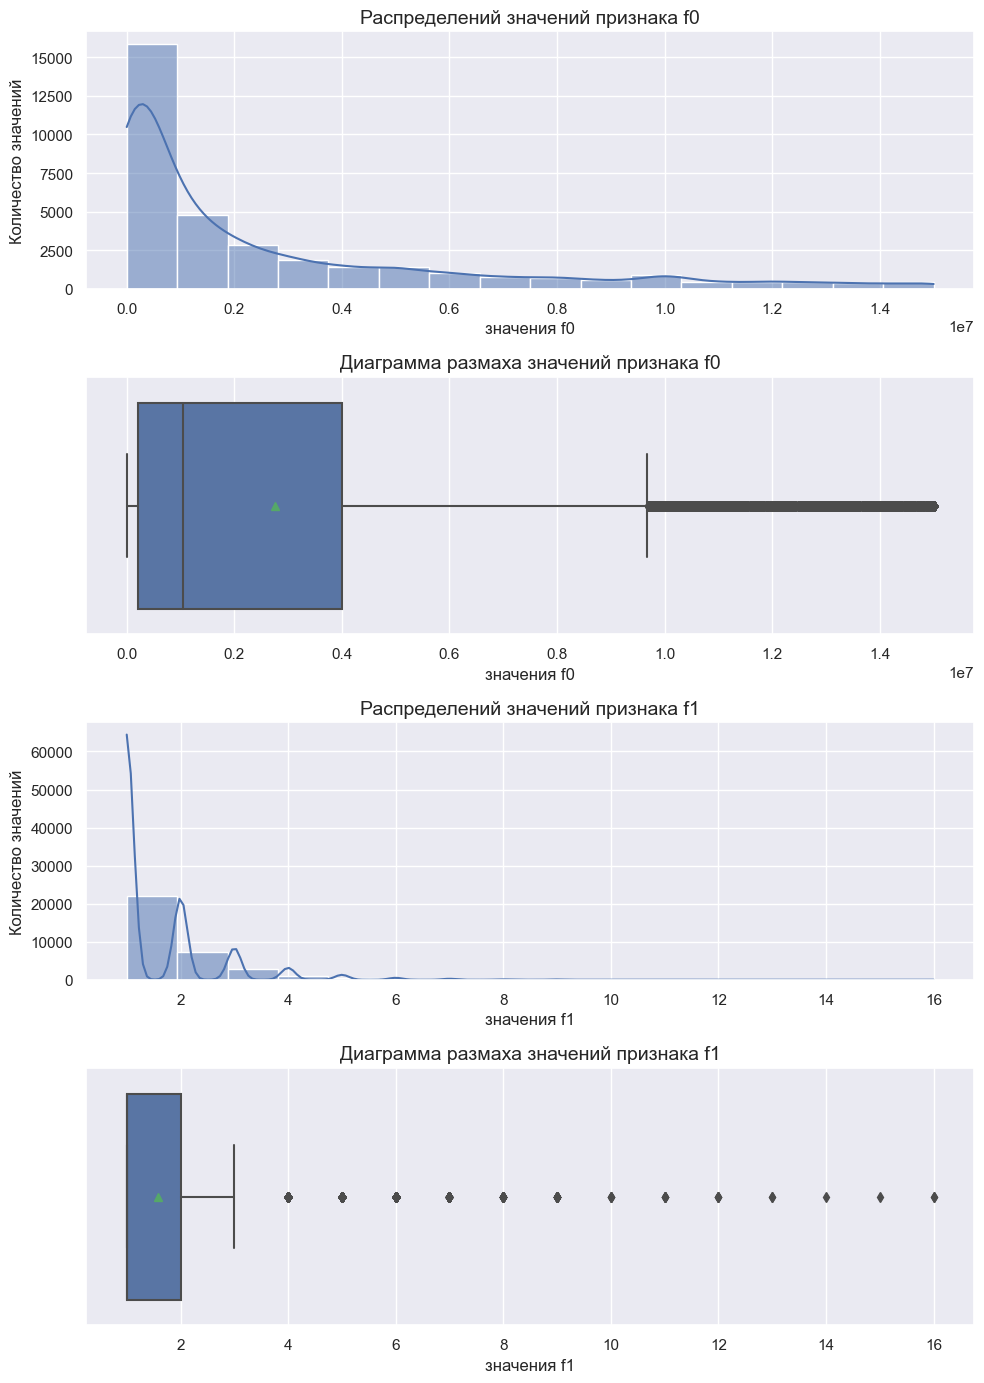

In [33]:
# Создаем переменные, которые станут агрументами функции
df = dfs[0]
columns = df.select_dtypes(include='number').columns.tolist()
col_numb = len(columns)
subplots = col_numb * 2

# Количество корзин определим по правилу Стёрджеса: число bins равно log2(n) + 1, где n - количество наблюдений
bins = [round((math.log2(len(dfs[0])) + 1))] * col_numb
figsize = (10,14)
title_h = ['Распределений значений признака f0','Распределений значений признака f1','Распределений значений признака f2',
           'Распределений запаса нефти в скважинах']
title_b = ['Диаграмма размаха значений признака f0','Диаграмма размаха значений признака f1',
           'Диаграмма размаха значений признака f2','Диаграмма размаха значений запаса нефти']
y = ['Количество значений'] * col_numb
x = ['значения f0','значения f1','значения f2','запас нефти']
y_b = [''] * col_numb

# Строим графики
plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y,x,y_b,x)

### Анализ категориальных признаков

### Проверка наличия дисбаланса в данных по целевой переменной

## Создание новых признаков

## Корреляционный анализ и финальный отбор признаков

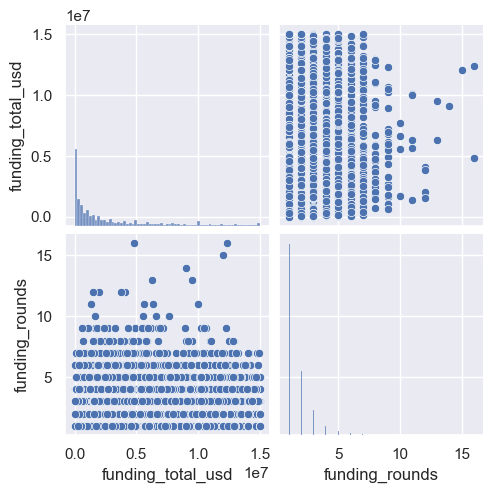

In [34]:
startups_train = dfs[0]

# посмотрим попарные отношения между признаками датафрейма обучающей выборки
sns.pairplot(startups_train);

In [35]:
startups_train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
5,Connected Sports Ventures,Mobile,"4,300,000.000",operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
7,Mesh Networks,Software,"4,300,000.000",operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
9,Vidatronic,Semiconductors,"1,250,500.000",operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN
12,Iberic Premium,NaN,"107,239.000",closed,NaN,NaN,NaN,NaN,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52509,Visionary Mobile,Biotechnology,"1,570,000.000",operating,USA,OR,"Salem, Oregon",Corvallis,3,2010-01-01,2011-09-20,2012-04-11,NaN
52512,Hello Curry,Hospitality,"500,000.000",operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaN
52513,Taskforce,Email|Messaging|Productivity Software,"50,000.000",operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN
52514,NetScaler,Security,"13,000,000.000",operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaN


In [36]:
# вычисление матрицы корреляции с использованием phik
corr_matrix_phik = startups_train.phik_matrix # (interval_cols=['salary','job_satisfaction_rate'])

In [37]:
# Маска для устранения дублирования в визуализации
mask = np.zeros_like(corr_matrix_phik)
#mask[np.triu_indices_from(mask)] = True

# Построение heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_phik, annot=True,cmap='GnBu') #,mask=mask)
plt.title('Phi_K матрица корреляций датасета', fontsize=14)
plt.ylabel('Признаки датафрейма')
plt.xlabel('Признаки датафрейма')
plt.show();

ValueError: Must pass 2-d input. shape=()

<Figure size 1200x800 with 0 Axes>

## Разработка моделей МО

### Подготовка данных для моделей

### Обучение моделей в пайплайне

### Оценка результатов

## Анализ важности признаков и рекомендации по повышению шанса на успех стартапа

## Общий вывод

Шаги, которые необходимо реализовать:
- [x]  Описать цели проекта, данные, которые будем использовать
- [x]  Загрузить данные, проверить форматы данных и преобразовать, где необходимо
- [ ]  Произвести предобработку данных
    - [ ]  Проанализировать с пропущенными значениями в признаках, решить как с ними поступить в каждом из случаев
    - [ ]  Проверить данные на дубликаты
    - [ ]  Попробовать выделить несколько основных категорий, около 10
        - [ ] 1)составить список основных категорий и функцию, которая будет сопоставлять данные с этим списком и присавивать нужное значение, затем создать новый столбец на их основе 2) обработать разделив на отдельные категории и работать с этим как с мультикласс-мультилейбл задачей 3) п.2 а потом при этом избавиться от неявных дубликатов (например поискав характерные части слов) 4) п. 3, а затем выбрать топ-N категорий по распространенности
        - [ ] попробовать векторизовать значения через word2vec или sentense-transformers
- [ ]  
- [ ]  Выполнить исследовательский анализ
- [ ]  Синтезировать новые признаки
- [ ]  Разобраться с дисбалансом классов, использовать adasync, Smote или SmoteTOMEK
- [ ]  Провести корреляционный анализ данных, убрать утечки таргета, если есть, выполнить окончательный отбор признаков
- [ ]  Создать пайплайн с подготовкой данных
    - [ ] Обработать каждый из столбцов нужным энекодером
    - [ ] Масшатабировать численные данные
    - [ ] Реализовать замену пропущенных значений на основе выводов из пункта 2
    - [ ]   
- [ ]  Создать пайплайн для обучения моделей
    - [ ] Выбрать какие модели использовать
    - [ ] Подобрать для них гиперпараметры
    - [ ] Не забыть произвести кросс-валидацию и выбрать лучшую
    - [ ] Добавить в каждую из моделей параметр cross_weights = 'balanced'
    - [ ] Зафиксировать метрики на трейне и на тестовой выборке
    - [ ] Построить таблицу истинности и оценить матрицу
- [ ] Сделать оценку важности признаков
- [ ] Привести данные, полученные по лучшей из моделей к нужному виду, для загрузки на Kaggle
- [ ] Сделать отчет с основными этапами работы и выводами, добавить его в Readme
- [ ] Грамотно оформить репозиторий на Github

Комментарии по проекту:
- очень важно поработать с признаками входными, хорошо их обработать
- начало 18 года - дата, после которой мы прогнозируем вероятность закрытия стартапа
- поработать с границей определения классов, по идее, для бизнеса важнее понимать во что вложиться и не прогореть, то есть им нужно максимальное количество результатов TP, а остальные не так важны, то есть нужно отбирать стартапы с самой маленькой вероятностью закрытия(хотя f1 score, по идее, учитывает и то и то)
- сильно несбалансированная целевая переменная, не забывать про проверку дисбаланса классов и модели, для его невилирования можно в моделях используемых использовать параметр (class_weights = balanced), так модель будет больше штрафовать минорный класс, следовательно и больше обращать на него внимение, также посмотреть сэмплирование (adasync, SMOTE, smoteTOMEK)

- проверить на мультиколлинеарность, не забыть убрать утечку целевого признака, она есть, это дата закрытия стартапа
- когда уже перейду к модели, составить план по перебору параметров, не забыть обосновать и лучше делать одно изменение за одну итерацию
- написать отчет общий, как я обычно делаю, перенести его в Readme на github
- не выкладывать на github сами датасеты и сторонние файлы, readme и исполненной тетрадки юпитера будет достаточно
